![](images/ohm_logo.png)

<h1><center>Bachelor Thesis</center></h1>

<h1><center><big>IT-Based textgeneration using NLP methods</big><br><hr> <i>State-of-the-art and design of a prototype </i></center></h1>

<center>from Tim Löhr</center>

# 1.0 Importing the Dependcies

In [1]:
from attention import AttentionLayer

import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup
import os

from nltk.corpus import stopwords   
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import backend as K 

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# 2.0 Loading the Data

In [2]:
#data = pd.read_csv('amazon-fine-food-reviews/Reviews.csv', nrows=10000)
#data.head()

In [3]:
#data.shape

In [4]:
frames = ['Article', 'Summary']
topics = ['business', 'entertainment', 'politics', 'sport', 'tech']

summaries = {topic: [] for topic in topics}
articles = {topic: [] for topic in topics}

summary = []
article = []

for frame in frames:
    for i, topic in enumerate(topics):
        _, _, files = next(os.walk("./BBC_News/" + frame + "/" + topic))
        
        for file in files:
            file = open("./BBC_News/" + frame + "/" + topic + "/" + file, 'rb')
            text = file.read()
            
            if (frame == "Article"):
                articles[topic].append(text)
                article.append(text)
            else:
                summaries[topic].append(text)
                summary.append(text)

In [5]:
dataset = {'Text': article, 'Summary': summary}

In [6]:
data = pd.DataFrame(dataset)

In [7]:
data.head()

,Text,Summary
0,"b'UK economy facing \'major risks\'\n\nThe UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group\...","b'""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said.The BCC found confidence increased in the quarter across both the manufacturing and s..."
1,b'Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.\n\nSom...,"b'At the same time, about 100,000 people are expected to converge on the Brazilian resort of Porto Alegre for the World Social Forum - the so-called ""anti-Davos"" for campaigners against globalisat..."
2,b'Asian quake hits European shares\n\nShares in Europe\'s leading reinsurers and travel firms have fallen as the scale of the damage wrought by tsunamis across south Asia has become apparent.\n\nM...,"b""The unfolding scale of the disaster in south Asia had little immediate impact on US shares, however.But the disaster has little impact on stock markets in the US and Asia.Shares in Munich Re and..."
3,"b'India power shares jump on debut\n\nShares in India\'s largest power producer, National Thermal Power Corp (NTPC) have risen 13% on their stock market debut.\n\nThe government\'s partial sell-of...","b'Shares in India\'s largest power producer, National Thermal Power Corp (NTPC) have risen 13% on their stock market debut.""Power needs in India are set to rise and NTPC will benefit from that.""NT..."
4,"b""Lacroix label bought by US firm\n\nLuxury goods group LVMH has sold its loss-making Christian Lacroix clothing label to a US investment group.\n\nThe Paris-based firm has been shedding non-core ...","b""LVMH said the French designer's haute couture and ready-to-wear labels had been purchased by the Falic Group for an unspecified sum.Luxury goods group LVMH has sold its loss-making Christian Lac..."


# 3.0 Data Preprocessing

In [8]:
#data = data[['Summary', 'Text']]

In [9]:
data.drop_duplicates(subset='Text')
data.dropna(axis=0, inplace=True)

In [10]:
data.shape

(2225, 2)

### Contraction Mapping

In [11]:
from contraction_mapping import contraction_mapping

contraction_mapping = contraction_mapping()

## Cleaning

### Text Cleaning

In [12]:
stop_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [13]:
text_cleaner(data['Text'][127])

'optimism remains housing property market remains robust despite recent slowdown according mortgage lender bradford bingley housebuilder george wimpey said buy let market bank major player would continue grow much faster wider mortgage market comments came reported rise profits wimpey reported rise profits said recent new home reservations better expected recent housing market surveys indicated property market cooled recent months several years rapid growth last week figures council mortgage lenders indicated popularity buy let mortgages key phenomenon housing boom could waning share buy let mortgage market said rates growth moderating sector continues grow rate considerably whole mortgage market overall said housing market fundamentals remain strong interest rates unemployment likely remain historically low levels real household incomes continue grow housing demand likely outstrip supply medium term despite upbeat tone shares morning trade analysts worried future earnings growth wimpe

In [14]:
data['Text'][127]

b'Optimism remains over UK housing\n\nThe UK property market remains robust despite the recent slowdown, according to mortgage lender Bradford & Bingley and housebuilder George Wimpey.\n\nB&B said the buy-to-let market - in which the bank is a major player - would continue to grow much faster than the wider mortgage market. The comments came as it reported a 6% rise in profits to \xc2\xa3280.2m ($532m). Wimpey reported a 19% rise in profits to \xc2\xa3450.7m and said recent new home reservations were better than expected.\n\nRecent housing market surveys have indicated that the UK property market has cooled in recent months after several years of rapid growth. Last week, figures from the Council of Mortgage Lenders (CML) indicated that the popularity of buy-to-let mortgages - a key phenomenon of the housing boom - could be waning.\n\nBut B&B - which has a 22% share of the UK buy-to-let mortgage market - said that while rates of growth were moderating, the sector "continues to grow at a

#### Cleaned text concatenate with DataFrame

In [15]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

### Summary Cleaning

In [16]:
data['Summary'][:10]

0    b'"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said.The BCC found confidence increased in the quarter across both the manufacturing and s...
1    b'At the same time, about 100,000 people are expected to converge on the Brazilian resort of Porto Alegre for the World Social Forum - the so-called "anti-Davos" for campaigners against globalisat...
2    b"The unfolding scale of the disaster in south Asia had little immediate impact on US shares, however.But the disaster has little impact on stock markets in the US and Asia.Shares in Munich Re and...
3    b'Shares in India\'s largest power producer, National Thermal Power Corp (NTPC) have risen 13% on their stock market debut."Power needs in India are set to rise and NTPC will benefit from that."NT...
4    b"LVMH said the French designer's haute couture and ready-to-wear labels had been purchased by the Falic Group for an unspecified sum.Luxury goods group LVMH has sold its loss

In [17]:
def summary_cleaner(text):
    newString = text.decode("utf-8")
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString + i + ' '  
    return newString

In [18]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

In [19]:
data.head()

,Text,Summary,cleaned_text,cleaned_summary
0,"b'UK economy facing \'major risks\'\n\nThe UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group\...","b'""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said.The BCC found confidence increased in the quarter across both the manufacturing and s...",economy facing major risks manufacturing sector continue face serious challenges next two years british chamber commerce said group quarterly survey companies found exports picked last three month...,_START_ despite some positive news for the export sector there are worrying signs for manufacturing the bcc said the bcc found confidence increased in the quarter across both the manufacturing and...
1,b'Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.\n\nSom...,"b'At the same time, about 100,000 people are expected to converge on the Brazilian resort of Porto Alegre for the World Social Forum - the so-called ""anti-Davos"" for campaigners against globalisat...",aids climate top davos agenda climate change fight aids leading list concerns first day world economic forum swiss resort davos business political leaders around globe listen prime minister tony b...,_START_ at the same time about people are expected to converge on the brazilian resort of porto alegre for the world social forum the so called anti davos for campaigners against globalisation for...
2,b'Asian quake hits European shares\n\nShares in Europe\'s leading reinsurers and travel firms have fallen as the scale of the damage wrought by tsunamis across south Asia has become apparent.\n\nM...,"b""The unfolding scale of the disaster in south Asia had little immediate impact on US shares, however.But the disaster has little impact on stock markets in the US and Asia.Shares in Munich Re and...",asian quake hits european shares shares europe leading reinsurers travel firms fallen scale damage wrought tsunamis across south asia become apparent people killed following massive underwater ear...,_START_ the unfolding scale of the disaster in south asia had little immediate impact on us shares however but the disaster has little impact on stock markets in the us and asia shares in munich r...
3,"b'India power shares jump on debut\n\nShares in India\'s largest power producer, National Thermal Power Corp (NTPC) have risen 13% on their stock market debut.\n\nThe government\'s partial sell-of...","b'Shares in India\'s largest power producer, National Thermal Power Corp (NTPC) have risen 13% on their stock market debut.""Power needs in India are set to rise and NTPC will benefit from that.""NT...",india power shares jump debut shares india largest power producer national thermal power corp risen stock market debut government partial sell ntpc part controversial programme privatise state run...,_START_ shares in india largest power producer national thermal power corp ntpc have risen on their stock market debut power needs in india are set to rise and ntpc will benefit from that ntpc has...
4,"b""Lacroix label bought by US firm\n\nLuxury goods group LVMH has sold its loss-making Christian Lacroix clothing label to a US investment group.\n\nThe Paris-based firm has been shedding non-core ...","b""LVMH said the French designer's haute couture and ready-to-wear labels had been purchased by the Falic Group for an unspecified sum.Luxury goods group LVMH has sold its loss-making Christian Lac...",lacroix label bought firm luxury goods group lvmh sold loss making christian lacroix clothing label investment group paris based firm shedding non core businesses focusing profitable brands includ...,_START_ lvmh said the french designer haute couture and ready to wear labels had been purchased by the falic group for a

### Distribution of the sequences

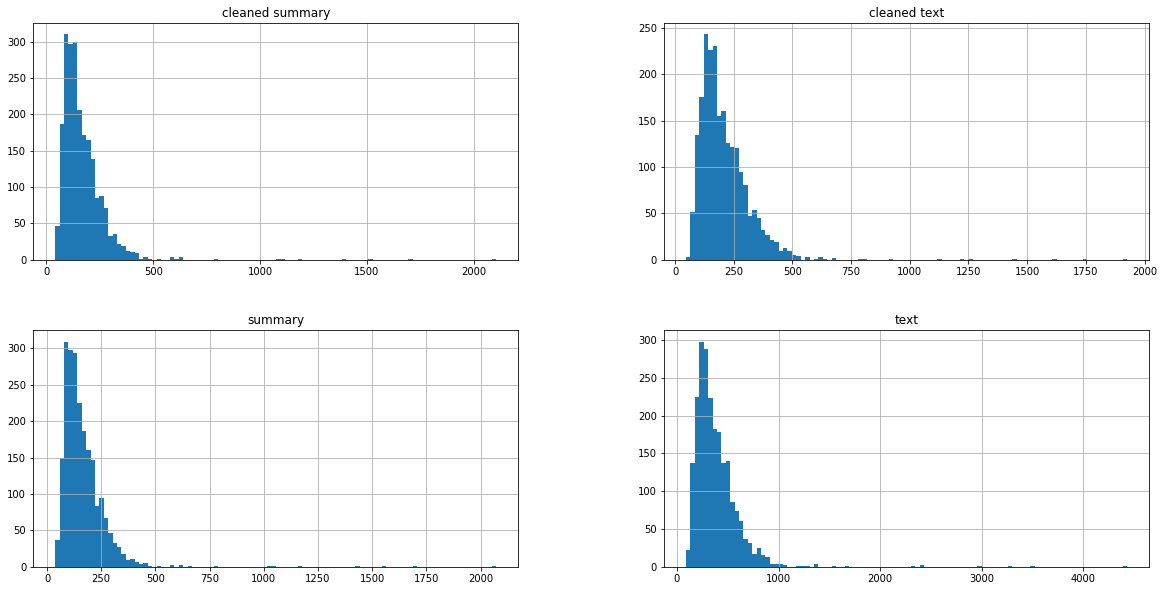

In [20]:
text_word_count = []
summary_word_count = []

c_text_word_count = []
c_summary_word_count = []

# populate the lists with sentence lengths
for i in data['Text']:
      text_word_count.append(len(i.split()))

for i in data['Summary']:
      summary_word_count.append(len(i.split()))
        
for i in data['cleaned_text']:
      c_text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      c_summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count,
                          'cleaned text': c_text_word_count, 'cleaned summary': c_summary_word_count})

length_df.hist(bins = 100, figsize=(20,10))

plt.show()

In [21]:
max_len_sum = [len(data.split()) for data in data['cleaned_summary']]
np.median(max_len_sum)

144.0

In [22]:
max_len_sum = [len(data.split()) for data in data['cleaned_text']]
np.median(max_len_sum)

185.0

In [23]:
max_len_text = 300 
max_len_summary = 100

### Preparing Tokenizer

In [24]:
X_train , X_test , y_train , y_test = train_test_split(data['cleaned_text'][:50], data['cleaned_summary'][:50], test_size=0.1, random_state=0, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(45,)
(5,)
(45,)
(5,)


#### Text Tokenizer

In [25]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train = x_tokenizer.texts_to_sequences(X_train) 
X_test = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1

#### Summary Tokenizer

In [26]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_test = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(45, 300)
(5, 300)
(45, 100)
(5, 100)


# 4.0 Model

In [28]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 500)     1495500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Model optimization

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#### Model fitting

In [31]:
try:
    model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})
    print("Model successfully loaded.")
except:
    print("Train Model...")
    history = model.fit([X_train, y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=3,
                    callbacks=[es],
                    batch_size=256, 
                    validation_data=([X_test,y_test[:,:-1]],
                                     y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
                   )
    model.save('model.h5')
    print("Model saved")

Train Model...
Train on 45 samples, validate on 5 samples
Epoch 1/3
45/45 [==============================] - 32s 719ms/sample - loss: 7.4996 - val_loss: 7.2413
Epoch 2/3
45/45 [==============================] - 26s 586ms/sample - loss: 7.3941 - val_loss: 6.6041
Epoch 3/3
45/45 [==============================] - 26s 568ms/sample - loss: 7.7961 - val_loss: 7.4298
Epoch 00003: early stopping
Model saved


# 5.0 Evaluation

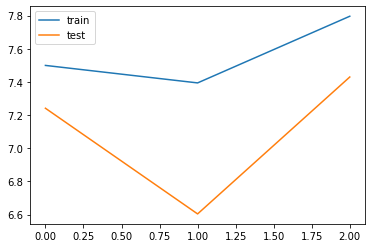

In [32]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

In [33]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

#### Inference

In [34]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

#### Inference Process

In [35]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [36]:
def seq2summary(input_seq):
    newString = ''
    
    for i in input_seq:
        if((i!=0 and i!= target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

def seq2text(input_seq):
    newString = ''
    
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
            
    return newString

In [37]:
for i in range(2):
    print("Review:", seq2text(X_test[i]))
    print("\n Original summary:", seq2summary(y_test[i]))
    print("\n Predicted summary:", decode_sequence(X_test[i].reshape(1,max_len_text)))
    print("\n")

Review: china top trader japan china become japan biggest trading partner according numbers japan finance ministry wednesday china japan trade compared ahead china came second change china growing economic japan imports exports china added highest figure japanese trade china since records began trade trade hurt one factors including month ban imports following discovery mad however economists predict china become even important japanese trading partner coming years tuesday figures showed china economy grew experts say overall growth picture remains strong analysts see two future growth china membership world trade organisation lower trade tariffs japan trade grew trillion half trillion trade december grew year ago trillion stronger expected exports 

 Original summary: china for of japan trade in compared with for the us during japan trade grew to trillion with more than half the trillion for by its trade with the us it with bn in trade with the us china the us to become japan biggest 